## Processamento das mensagens

In [1]:
import pandas as pd
import dataframe_image as dfi
import matplotlib
import matplotlib.pyplot as plt
import statistics
import pymongo
import matplotlib.pyplot as plt
import numpy as np
from numpy import unravel_index
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from collections import Counter
from random import sample, randint

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["facebook"]

#### Formata texto

In [2]:
CARACTERE = '0123456789abcdefghijklmnopqrstuvwxyz '

def preprocessamento_dados(sentenca):
    sentenca = sentenca.lower()
    sentenca = sentenca.translate( str.maketrans( 'âêîôûáéíóúãõ', 'aeiouaeiouao' ))
    sentenca = sentenca.split()
    
    nova_sentenca=[]
    for ns in sentenca:
        nova_sentenca.append(''.join([ ch for ch in ns if ch in CARACTERE ]))
    return nova_sentenca

## Análise de dados

#### Cria dicionário com palavras selecionadas

In [3]:
palavra_categoria={} #Dicionario={palavra:categoria}
palavra_frequencia={} #Dicionario={palavra:frequencia_que_cada_palavra_aparece_no_texto}
df = pd.read_excel('Palavras_selecionadas.xlsx')

for x in range(df.shape[0]):
    for i in range(df.shape[1]):
        if df.iloc[x,i]==df.iloc[x,i]:
            palavra_frequencia[df.iloc[x,i]]=0
            palavra_categoria[df.iloc[x,i]]=df.columns[i]

In [4]:
df.columns

Index(['Política', 'Religião', 'Estudo', 'Trabalho', 'Doutrina',
       'Relacionamento', 'Futebol', 'Esporte', 'Artes ', 'Lúdico', 'Signo',
       'Música', 'Comida', 'Animal', 'Maquiagem', 'Droga', 'Pandemia',
       'Tecnologia', 'Facebook'],
      dtype='object')

#### Conta quantas categorias cada perfil reagiu 

In [5]:
###palavra_categoria

totalperfis=0 #Quantidade total de perfis
###qPostagem=0
qPostagemTotal=0  #Quantidade total de postagens
qPostagemNotNull=0  #Quantidade de postagens diferente de null
qPostagemValida=0  #Quantidade de postagens validas
###perfil_amigos={}
###perfil_pub={}
perfil_reacoes={} #Quantidade de vezes que cada perfil reagiu a uma catogoria {perfil:{categoria:frequencia}}
###lista_palavras_amigos={}
###localizacao_perfil={}
categorias_postagem={} #Quantidade de vezes que uma palavra, de cada cateogia, aparece na publicação {categoria:frequencia}

dic_categoria={} #Dicionario base para ser adicionado a cada perfil
for x in df.columns:
    dic_categoria[x]=0

###aux_loca=1
###aux_perfil=0

mycol = mydb["perfils"]
for dado in mycol.find():
    
    for postagem in dado['postagens']:
        valido=0
        qPostagemTotal+=1
        
        #Adiciona o perfil e os amigos na população (inicializa as variaveis que armazena as reações)
        if dado['identidadeFacebook'] not in perfil_reacoes:
            totalperfis+=1
            perfil_reacoes[dado['identidadeFacebook']]={}
            for dc in dic_categoria:
                perfil_reacoes[dado['identidadeFacebook']][dc]=0
        for amigo in postagem['reacoes']:
            if amigo['usuario'] not in perfil_reacoes:
                totalperfis+=1
                perfil_reacoes[amigo['usuario']]={}
                for dc in dic_categoria:
                    perfil_reacoes[amigo['usuario']][dc]=0
                    
        #Verifica quais categorias aparecem na publicação        
        if postagem['mensagem']!=None and postagem['mensagem']!=' ':
            qPostagemNotNull+=1
            for dc in dic_categoria:
                categorias_postagem[dc]=0 
            listPalavras=[]
            new= preprocessamento_dados(postagem['mensagem'])
            for palavra in new:
                if palavra!='':
                    if palavra in palavra_frequencia:
                        categorias_postagem[palavra_categoria[palavra]]=1
                        valido=1
            #Se a publicação for valida, ou seja, se pelo menos uma palavra da postagem possuir uma categoria
            if valido:
                qPostagemValida+=1
                #Adiciona as categorias q aparecem na publicação na variavel de cada perfil
                for p in postagem['reacoes']:
                    if p['usuario']!=dado['identidadeFacebook']:
                        for x in categorias_postagem:
                            if categorias_postagem[x]>0:
                                perfil_reacoes[p['usuario']][x]+=1
                for x in categorias_postagem:
                    if categorias_postagem[x]>0:
                        perfil_reacoes[dado['identidadeFacebook']][x]+=1

#Guarda o total de reações de cada perfil. ex:abc 0-1-1-0-0-0-1-0-1-1-1 = 6 
#perfil_reacoes_total[abc]=6
perfil_reacoes_total={}   
for x in perfil_reacoes:
    perfil_reacoes_total[x]=0
    for y in perfil_reacoes[x]:
        if perfil_reacoes[x][y]>0:
            perfil_reacoes_total[x]+=1

#Classifica os perfis que reagiram a nenhuma, um, duas,..., dez ou mais categorias
dic_num={1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
nenhum=0
for i in perfil_reacoes_total:
    if perfil_reacoes_total[i]>0 and perfil_reacoes_total[i]<10:
        dic_num[perfil_reacoes_total[i]]+=1
    elif perfil_reacoes_total[i]>=10:
        dic_num[10]+=1
    else:
        nenhum+=1
        

print("Perfis com nenhuma reação valida=",nenhum)
print("Quant_catgoria: Quant_perfis",dic_num)
print("Total de perfis=",totalperfis)
print("Total de postagens=",qPostagemTotal)
print("Total de postagens não vazias=",qPostagemNotNull)
print("Total de postagens validas=",qPostagemValida)

Perfis com nenhuma reação valida= 35570
Quant_catgoria: Quant_perfis {1: 7403, 2: 2367, 3: 719, 4: 316, 5: 160, 6: 149, 7: 58, 8: 42, 9: 16, 10: 29}
Total de perfis= 46829
Total de postagens= 25685
Total de postagens não vazias= 15748
Total de postagens validas= 3618


#### Cria a matriz de amizade

In [6]:
id_perfil={} #Relação do indice e nomePerfil
perfil_id={} #Relação do nomePerfil e indice
lista_perfis_selecionados=[] #Lista com perfis selecionados
qPerfisValidos=0 #Quantidade de perfis validos

#Cria lista com perfis selecionados, ou seja q reagiu a mais de 2 categorias
for i in perfil_reacoes_total:
    if perfil_reacoes_total[i]>2:
        id_perfil[qPerfisValidos]=i
        perfil_id[i]=qPerfisValidos
        lista_perfis_selecionados.append(i)
        qPerfisValidos+=1
        
matriz_Perfil=[[0 for i in range(qPerfisValidos)] for y in range(qPerfisValidos)] #Matriz de adjacencia da amizade entre perfis validos
lista_Quant_amigo=[0 for i in range(qPerfisValidos)] #Armazena quantos amigos validos cada perfil tem

#Preenche matriz
mycol = mydb["perfils"]
for dado in mycol.find():
    name= dado['identidadeFacebook']
    if name in perfil_id:
        for amigo in dado['amigos']:
            if amigo in perfil_id:
                matriz_Perfil[perfil_id[amigo]][perfil_id[name]]=1
                matriz_Perfil[perfil_id[name]][perfil_id[amigo]]=1


aux=0
count0=0
count1=0
count2a9=0
count10=0
for i in matriz_Perfil:
    som=sum(i)
    lista_Quant_amigo[aux]=som
    if som==0:
        count0+=1
    if som==1:
        count1+=1
    if som<=10 and som>1:
        count2a9+=1
    if som>10:
        count10+=1
    aux+=1
    
print("Total de perfis = ",qPerfisValidos)   
print("Perfis sem amigos = ",count0)
print("Perfis com 1 amigo = ",count1)
print("Perfis com 2 a 10 amigos = ",count2a9)
print("Perfis com mais de 10 amigos = ",count10)
'''
contador=0
dic_contador={}
for tam in lista_Quant_amigo:
    if tam in dic_contador:
        dic_contador[tam]=dic_contador[tam]+1
    else:
        dic_contador[tam]=1
    contador+=1
'''

Total de perfis =  1489
Perfis sem amigos =  3
Perfis com 1 amigo =  873
Perfis com 2 a 10 amigos =  530
Perfis com mais de 10 amigos =  83


'\ncontador=0\ndic_contador={}\nfor tam in lista_Quant_amigo:\n    if tam in dic_contador:\n        dic_contador[tam]=dic_contador[tam]+1\n    else:\n        dic_contador[tam]=1\n    contador+=1\n'

## Cria DF perfilXcategoria

In [7]:
perfil = pd.DataFrame(0, index=lista_perfis_selecionados, columns=df.columns)


###palavra_categoria

dic_categoria={}
for x in df.columns:
    dic_categoria[x]=0

##perfil_amigos={}
###perfil_pub={}
perfil_reacoes={}
###lista_palavras_amigos={}
###localizacao_perfil={}
categorias_postagem={}

###aux_loca=1
###aux_perfil=0

mycol = mydb["perfils"]
for dado in mycol.find():
    for postagem in dado['postagens']:
        if postagem['mensagem']!=None and postagem['mensagem']!=' ':
            for dc in dic_categoria:
                categorias_postagem[dc]=0 
            postagem_limpa= preprocessamento_dados(postagem['mensagem'])
            for palavra in postagem_limpa:
                if palavra!='':
                    if palavra in palavra_frequencia:
                        categorias_postagem[palavra_categoria[palavra]]=1
                        valido=1
            if valido:
                for p in postagem['reacoes']:
                    if p['usuario'] in lista_perfis_selecionados and p['usuario']!=dado['identidadeFacebook']:
                        for x in categorias_postagem:
                            if categorias_postagem[x]>0:
                                if perfil.loc[p['usuario'],x]==0:
                                    perfil.loc[p['usuario'],x]=10.1
                                else:
                                    perfil.loc[p['usuario'],x]=perfil.loc[p['usuario'],x]+0.1
                    
                if dado['identidadeFacebook'] in lista_perfis_selecionados:
                    for x in categorias_postagem:
                        if categorias_postagem[x]>0:
                            if perfil.loc[dado['identidadeFacebook'],x]==0:
                                perfil.loc[dado['identidadeFacebook'],x]=10.1
                            else:
                                perfil.loc[dado['identidadeFacebook'],x]=perfil.loc[dado['identidadeFacebook'],x]+0.1


#### Distância Euclidiana

In [8]:
matriz_dist=[[0 for i in range(qPerfisValidos)] for y in range(qPerfisValidos)]

for i in range(qPerfisValidos):
    for y in range(i,qPerfisValidos):
        dist=distance.euclidean(perfil.loc[id_perfil[i],:], perfil.loc[id_perfil[y],:])
        matriz_dist[i][y]=dist
        matriz_dist[y][i]=dist

#### Teste de escala

Mede a Distância Euclidiana entre um perfil que não reagiu a nenhuma categoria e um perfil que reagiu a 1,2,3...n categorias.
Com essas distâncias é possivel determinar os valores das escalas

In [9]:
mt=[] 
for i in range(df.shape[1]+1):
    mt.append([0 if i<=x else 10.1 for x in range(df.shape[1])])
    
perfil_test = pd.DataFrame(mt, columns=df.columns)
cont_test=perfil_test.shape[0]

matriz_dist_test=[[0 for i in range(cont_test)] for y in range(cont_test)]
for i in range(cont_test):
    for y in range(i,cont_test):
        dist=distance.euclidean(perfil_test.loc[i,:], perfil_test.loc[y,:])
        matriz_dist_test[i][y]=dist

for i in range(cont_test):
    print(i," = ",matriz_dist_test[0][i])

0  =  0.0
1  =  10.1
2  =  14.28355697996826
3  =  17.49371315644566
4  =  20.2
5  =  22.584286572747875
6  =  24.739846402110096
7  =  26.722088241752363
8  =  28.56711395993652
9  =  30.299999999999997
10  =  31.93900436770063
11  =  33.49791038258954
12  =  34.98742631289132
13  =  36.41606788218629
14  =  37.79073960641681
15  =  39.117131796694906
16  =  40.4
17  =  41.64336681873837
18  =  42.85067093990478
19  =  44.0248793297608


0.00 <= X <= 17.32   Muito similar  (1 2 3) 

17.32 < X <= 26.45   Similar (4 5 6 7) 

26.45 < X <= 34.64   Irrelevante (8 9 10 11 12)

34.64 < X <= 44.0    Dissimilar (13 14 15 16)

44.0  < X            Muito Dissimilar (17 18 19)

#### Função para calcular amizade dos perfis

In [10]:
lista_moda=[0 for x in range(qPerfisValidos)] #Lista com a moda de cada perfil (Quant_amigos,moda)

#Classifica amizade de cada perfil
for y in range(qPerfisValidos):
    amigo_dist=[]
    for x in range(qPerfisValidos):
        if matriz_Perfil[y][x]==1: 
            dist = matriz_dist[x][y] 
            if dist < 20.2:
                amigo_dist.append(5)
            elif (20.2 <= dist) and (dist<28.56):
                amigo_dist.append(4)
            elif (28.56 <= dist) and (dist<36.41):
                amigo_dist.append(3)
            elif (36.41 <= dist) and (dist<41.64):
                amigo_dist.append(2)
            else:
                amigo_dist.append(1)
    
    #Calcula a moda de cada lista
    if amigo_dist!=[]:
        try:
            moda = statistics.mode(amigo_dist)
        except:
            contador_aux=[0,0,0,0,0]
            for i in amigo_dist:
                contador_aux[i-1]=contador_aux[i-1]+1
            valor_max=max(contador_aux)
            for i in range(len(contador_aux)):
                if contador_aux[i]==valor_max:
                    moda=i+1
        lista_moda[y]=(len(amigo_dist),moda)
    else:
        lista_moda[y]=(len(amigo_dist),0)


[0, 4, 81, 406, 382]


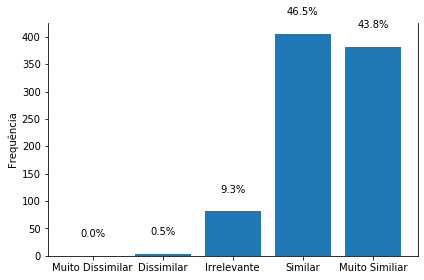

[0, 0, 44, 270, 216]


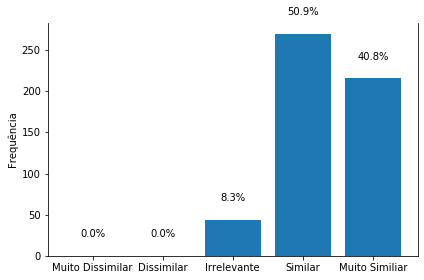

[0, 0, 7, 49, 27]


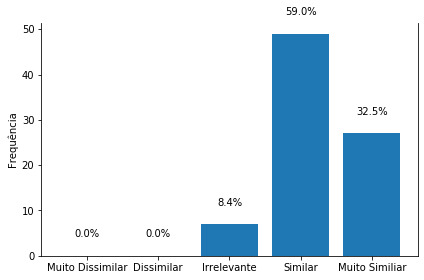

[0, 4, 132, 725, 625]


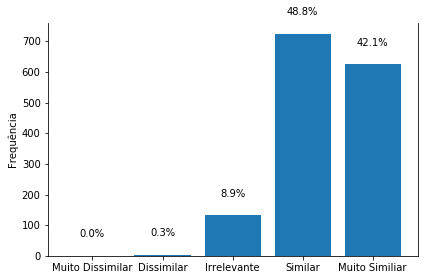

In [11]:
#Definições de cda gráfico
limites=[(0,1),(1,10),(10,1000),(0,1000)]
nomes_grafico=['1amigo.png', '2a10amigos.png', 'Mais10amigos.png', 'Todos.png' ]
labels = ['Muito Dissimilar','Dissimilar','Irrelevante','Similar','Muito Similiar']

for grafico in range(len(limites)):
    contador_aux=[0,0,0,0,0,0]
    #Seleciona os perfis que se encaixam no range
    for i in lista_moda:
        if i[0]>limites[grafico][0] and i[0]<=limites[grafico][1]:
            contador_aux[i[1]]+=1
    men_means=contador_aux[1:]

    #Definições do grafico
    x = np.arange(len(labels)) 
    width = 0.5  # Tamanho da barra
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, men_means)
    ax.set_ylabel('Frequência')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    #Atribui a porcentagem em cima das barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            absolute=(height*100)/np.sum(men_means)
            ax.annotate('{:.1f}%\n'.format(absolute),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    ax.spines['top'].set_visible(False)
    print(men_means)
    fig.tight_layout()
    fig.savefig(nomes_grafico[grafico], transparent=True)
    plt.show()


### Formar grupo

In [12]:
#Calcula o centroide de um cluster
def centroide(pontos):
    cent = [sum(ponto)/len(ponto) for ponto in zip(*pontos)]

    return tuple(cent)

In [13]:
#Calcula o SSE de um conjunto de clusteres
def sse(df_grupo, g, alg):
    ###print("df_grupo",df_grupo)
    sumTotal=0
    for x in range(g):
        df_g=df_grupo[df_grupo[alg]==x].iloc[:,:19]
        pontos=[]
        for i in range(len(df_g)):
            pontos.append(df_g.iloc[i])
        cent=centroide(pontos)

        suum=0
        for i in range(len(df_g)):
            for d in range(19):
                suum+=distance.euclidean(df_g.iloc[i][d], cent[d])**2
        sumTotal+=suum
    return sumTotal

#### Hierarchy

In [14]:
def hierarquico(lista, perfil, total, grupo):
    ####print("perfil=",perfil)
    ###lista_resposta=[]
    #Cria dendrograma
    scaler = StandardScaler()
    base = scaler.fit_transform(perfil)
    dendrograma = dendrogram(linkage(base, method = 'ward'))
    
    #Defini tamanho e faz a divisão dos clusteres
    cluster = AgglomerativeClustering(n_clusters = grupo, affinity = 'euclidean', linkage = 'ward')
    cluster.fit_predict(base)
    previsoes = cluster.labels_
    
    #Adiciona o numeros dos grupos no dataframe
    perfil['hierarchy']=previsoes
    #Calcula o SSE dos clusteres
    som_tl=sse(perfil,grupo,'hierarchy')

    return som_tl

#### Hierarchy Modificado

In [18]:
def hierarquicoModificao(lista, perfil3, total, grupo):
    
    matriz_dist2=pd.DataFrame(matriz_dist)
    new_matriz_dist=matriz_dist2.iloc[lista,lista]
    limit=1000000.0

    arrOrig= np.array(([[new_matriz_dist.iloc[i,j] if new_matriz_dist.iloc[i,j]!=0.0 else limit for i in range(total)]for j in range(total)]))
    arr= np.array(([[new_matriz_dist.iloc[i,j] if new_matriz_dist.iloc[i,j]!=0.0 else limit for i in range(total)]for j in range(total)]))
    matriz_outra=np.array(([[limit for i in range(total)]for j in range(grupo)]))
    list_resposta=[1000000.0 for j in range(total)]
    disponivel=[j for j in range(total)]
    
    m = [[] for i in range(grupo)]
    g=0
    
    #Defini os grupos com os pares mais proximos
    while g<grupo:
        tp=unravel_index(arr.argmin(), arr.shape)
        m[g].append(tp[0])
        m[g].append(tp[1])
        disponivel.remove(tp[0])
        disponivel.remove(tp[1])
        for i in range(total):
            arr[tp[0]][i]=limit
            arr[i][tp[0]]=limit
            arr[tp[1]][i]=limit
            arr[i][tp[1]]=limit
        g+=1

    #Adiciona os elementos disponiveis dentro dos grupos mas proximos e menores que o tamanho maximo
    while len(disponivel)>0:
        for i in disponivel:
            for y in range(grupo):
                if len(m[y])<(total/grupo):
                    matriz_outra[y][i]=dist_grupo(i,m[y],arrOrig) 
                else:
                    matriz_outra[y][i]=limit
        tp=unravel_index(matriz_outra.argmin(), matriz_outra.shape)
        m[tp[0]].append(tp[1])
        disponivel.remove(tp[1])

        for i in range(grupo):
            matriz_outra[i][tp[1]]=limit

    for i in range(grupo):
        for y in range(int(total/grupo)):
            list_resposta[m[i][y]]=i
    
    #Adiciona o numeros dos grupos no dataframe
    perfil_rand['Meu2']=list_resposta
    
    #Calcula o SSE dos clusteres
    som_tl=sse(perfil_rand,grupo,'Meu2')

    return som_tl

In [16]:
def dist_grupo(n,lis,arrOrig):
        somatorio=0
        for i in lis:
            somatorio+=arrOrig[n][i]
        resposta=somatorio/len(lis)
        return resposta

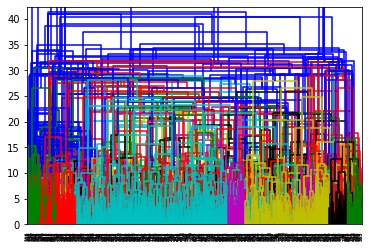

In [19]:
grupos=[2,5,10,25]
numbers = [10,50,100,500]
execursao = [1,2,3,4,5]
algo = ['HT','HM','HM-HT']

lista_df=[] #Lista com os dataFrames
lista_porcent=[] #Lista com porcentagens 

hier_index=pd.MultiIndex.from_product([execursao,algo],names=['Exec','Alg'])
for grupo in grupos:
    if grupo==2 or grupo==5:
        df = pd.DataFrame('0',index=hier_index,columns=['10 PERFIS','50 PERFIS','100 PERFIS','500 PERFIS'])
    else:
        df = pd.DataFrame('0',index=hier_index,columns=['50 PERFIS','100 PERFIS','500 PERFIS'])
    lista_df.append(df)

cont=[0,0]
for t in execursao:
    for y in range(len(numbers)):
        lista_rand = sample(range(qPerfisValidos), numbers[y])
        perfil_rand=perfil.iloc[lista_rand,:19]
        aux=[]
        for x in range(len(grupos)):
            if y==0 and (x==2 or x==3):
                aux.append(0)
            else:
                if x==2 or x==3:
                    ln=y-1
                else:
                    ln=y
                fo=hierarquico(lista_rand, perfil_rand, numbers[y], grupos[x])
                lista_df[x].iloc[t*3-3][ln]='{:.2f}'.format(fo)
                foM=hierarquicoModificao(lista_rand, perfil_rand, numbers[y], grupos[x])
                lista_df[x].iloc[t*3-2][ln]='{:.2f}'.format(foM)
                lista_df[x].iloc[t*3-1][ln]='{:.2f}%'.format(((foM*100)/fo)-100)
                aux.append(((foM*100)/fo)-100)
        lista_porcent.append(aux)
        #print(lista_porcent)
        #print(lista_df)

#print('----------------------------')
#print(lista_df)

In [ ]:
#Contrução dos graficos
for ex in execursao:    
    porc=[]
    for i in range(len(numbers)):
        l=[]
        if i==2 or i==3:
            #Zera quando for 10 e 25 perfis para 10 cluteres
            l.append(0)
        for y in lista_df[i].iloc[ex*3-1].values:
            l.append(float(y.split('%')[0]))
        porc.append(l)
        
    print(porc)
    barWidth = 0.2
    plt.figure(figsize=(10,5))

    r1 = np.arange(len(porc[0]))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    plt.bar(r1, porc[0], width=barWidth, label='2 Clusters')
    plt.bar(r2, porc[1], width=barWidth, label='5 Clusters')
    plt.bar(r3, porc[2], width=barWidth, label='10 Clusters')
    plt.bar(r4, porc[3], width=barWidth, label='25 Clusters')

    plt.xlabel('Quantidade de perfis')
    plt.xticks([r+barWidth for r in range(len(porc[0]))],['10 Perfis','50 Perfis','100 Perfis','500 Perfis'])
    plt.ylabel('Porcentagens')
    plt.title('Execução '+str(ex))

    plt.legend()
    plt.savefig('Barra'+str(ex)+'.png')

In [ ]:
lista_df